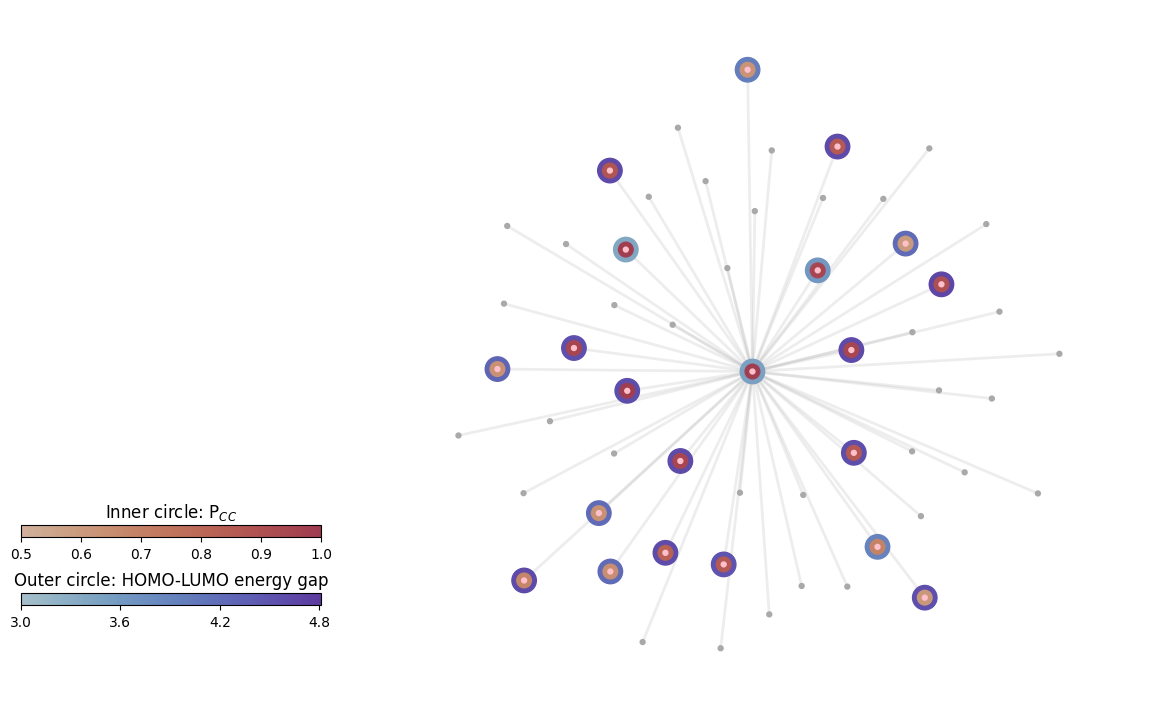

In [3]:
import random

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Circle
from matplotlib.cm import ScalarMappable
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import MACCSkeys
from matplotlib.colors import LinearSegmentedColormap

# Load the CSV file
df = pd.read_csv('./CA_pcc_homolumo.csv')
random.seed(42)
# Build the network graph
G = nx.Graph()

def get_color(value, cmap, vmin, vmax):
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    return cmap(norm(value))

# Define a measure of molecular similarity (e.g., using RDKit's MACCS fingerprints)
def calculate_similarity(mol1, mol2):
    maccs1 = MACCSkeys.GenMACCSKeys(mol1)
    maccs2 = MACCSkeys.GenMACCSKeys(mol2)
    return DataStructs.TanimotoSimilarity(maccs1, maccs2)

# Add edges between each pair of molecules in the network graph, but only if one of the molecules is Phz
for i, row1 in df.iterrows():
    mol1 = Chem.MolFromSmiles(row1['smiles'])
    if mol1 is not None:
        node1_label = row1['label']
        G.add_node(node1_label, highlight=row1['highlight'], pcc=row1['Pcc'], homo_lumo=row1['HOMO-LUMO'])
        for j, row2 in df.iterrows():
            if i < j:  # Avoid duplicate comparisons
                mol2 = Chem.MolFromSmiles(row2['smiles'])
                if mol2 is not None:
                    node2_label = row2['label']
                    similarity = calculate_similarity(mol1, mol2)
                    if similarity > 0.45:
                        if 'Phz' in node1_label or 'Phz' in node2_label:
                            G.add_edge(node1_label, node2_label, weight=similarity)
pos = nx.spring_layout(G,seed=42)

# Use matplotlib for visualization
fig, ax = plt.subplots(figsize=(12, 8))
# You can adjust the following parameters to suitable values to move the graph to the desired position
plt.subplots_adjust(left=0.3, bottom=0.105, right=0.98, top=0.98)

edges = G.edges()
nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color='darkgray', alpha=0.2,width=2)  # Draw edges, alpha corresponds to transparency, width corresponds to thickness

# Two different colormaps, 0.1,0.5 means taking the interval from 0.1 to 0.5 of the entire orange colormap
cmap_name_orange = 'Oranges_0.15_0.6'
new_cmap_orange = LinearSegmentedColormap.from_list(cmap_name_orange, plt.cm.twilight_r(np.linspace(0.1, 0.30, 100)))
cmap_name_blue = 'Blues_0.15_0.6'
new_cmap_blue = LinearSegmentedColormap.from_list(cmap_name_blue, plt.cm.twilight(np.linspace(0.1, 0.35, 100)))
# Draw nodes
for node, (x, y) in pos.items():
    highlight = G.nodes[node]['highlight']
    pcc = G.nodes[node]['pcc']
    homo_lumo = G.nodes[node]['homo_lumo']
    # inner_color corresponds to the color of the highlighted node's center, darkgray corresponds to the color of the marked node's center
    inner_color = 'pink' if highlight == 1 else 'darkgray'
    outer_color = get_color(pcc, new_cmap_orange, 0.5, 1.0)
    homo_lumo_color = get_color(homo_lumo, new_cmap_blue, 3, 4.81)

    # Draw inner circle, 0.008 is the radius size, alpha is the transparency
    circle1 = Circle((x, y), 0.008, color=inner_color, fc=inner_color, ec=inner_color, alpha=1, zorder=4)
    ax.add_patch(circle1)

    if highlight == 1:
        # Draw outer circle
        circle2 = Circle((x, y), 0.024, color=outer_color, fc=outer_color, ec=outer_color, alpha=1, zorder=3)
        ax.add_patch(circle2)

        # Draw third circle
        circle3 = Circle((x, y), 0.040, color=homo_lumo_color, fc=homo_lumo_color, ec=homo_lumo_color, alpha=1, zorder=2)
        ax.add_patch(circle3)
# The following line is the label for each data point, uncomment it to regenerate the graph with labels
# nx.draw_networkx_labels(G, pos, font_size=10, font_family="sans-serif", verticalalignment="top", ax=ax)

# ax.set_title('Chemical Space Network with Labels',loc='center')
ax.axis('equal')
ax.axis('off')  # Turn off the coordinate axis

# Add color bars, distance from the left edge, distance from the bottom edge, width of the color bar, height of the color bar
cbar_ax1 = fig.add_axes([0.025, 0.320, 0.25, 0.015])  # [left, bottom, width, height]
cbar_ax2 = fig.add_axes([0.025, 0.235, 0.25, 0.015])  # [left, bottom, width, height]

sm = plt.cm.ScalarMappable(cmap=new_cmap_orange, norm=plt.Normalize(0.5, 1.0))
sm.set_array([])
cbar1 = plt.colorbar(sm, cax=cbar_ax1, orientation='horizontal')
cbar1.ax.set_title('Inner circle: P$_{CC}$')

sm2 = plt.cm.ScalarMappable(cmap=new_cmap_blue, norm=plt.Normalize(3, 4.81))
sm2.set_array([])
cbar2 = plt.colorbar(sm2, cax=cbar_ax2, orientation='horizontal')
cbar2.ax.set_title('Outer circle: HOMO-LUMO energy gap')
cbar2.set_ticks(np.arange(3, 4.81, 0.6)) # Set ticks at intervals of 0.6

plt.savefig('chemical_space_network_no_labels.png', bbox_inches='tight',transparent=True)
plt.show()